<a href="https://colab.research.google.com/github/patisankar/customer-coupon-acceptance/blob/main/module5_dirver_coupon_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic
import plotly.graph_objects as go
from plotly.subplots import make_subplots

1. Read in the `coupons.csv` file.

In [ ]:
data = pd.read_csv('data/coupons.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


2. Investigate the dataset for missing or problematic data.


In [ ]:
percent_missing_per_column = data.isnull().sum() * 100 / len(data)
print(percent_missing_per_column)

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64


## 3. Decide what to do about your missing data -- drop, replace, other
It shows that the 'car' column has a very high percentage of missing values (99.15%), and several other columns ('Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50') have a small percentage of missing values. Hence, the plan is to drop the 'car' column and fill the missing values in the other columns with their respective modes.

In [ ]:
data= data.drop('car', axis=1)

In [ ]:
# Fill missing values in specified columns with the mode of each column
data['Bar'] = data['Bar'].fillna(data['Bar'].mode()[0]);
data['CoffeeHouse'] = data['CoffeeHouse'].fillna(data['CoffeeHouse'].mode()[0]);
data['CarryAway'] = data['CarryAway'].fillna(data['CarryAway'].mode()[0]);
data['RestaurantLessThan20'] = data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].mode()[0]);
data['Restaurant20To50'] = data['Restaurant20To50'].fillna(data['Restaurant20To50'].mode()[0]);


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12684 non-null  object
 15  CoffeeHouse           12684 non-null

In [ ]:
# to calculate total count, accepted, rejected, and their percentages
def bivariate_analysis(df, column_name):
  # Group by the specified column and aggregate the 'Y' (acceptance) column
  summary_df = df.groupby(column_name)['Y'].agg(
    Total='count',
    Accepted = lambda x: (x==1).sum(),
    Rejected = lambda x: (x==0).sum()
   )
  # Calculate the acceptance percentage
  summary_df['Accepted%'] = round(summary_df['Accepted'] / summary_df['Total'] * 100, 3)
  # Calculate the acceptance percentage
  summary_df['Rejected%'] = round(summary_df['Rejected'] / summary_df['Total'] * 100, 3)
  return summary_df.reset_index().sort_values(by='Total', ascending=False)


4. **What proportion of the total observations chose to accept the coupon?**

This analysis aims to identify customers who accept the coupon and those who reject it. Our goal is to leverage these insights to increase the acceptance rate for this specific coupon among targeted segments

Proportion = Number of observations that accepted the coupon / Total number of observations

In [ ]:
coupon_df = data[['coupon','Y']].copy()


In [ ]:

proportion_by_group = bivariate_analysis(data, 'coupon')
print(proportion_by_group)



                  coupon  Total  Accepted  Rejected  Accepted%  Rejected%
2           Coffee House   3996      1995      2001     49.925     50.075
4        Restaurant(<20)   2786      1970       816     70.711     29.289
1  Carry out & Take away   2393      1760       633     73.548     26.452
0                    Bar   2017       827      1190     41.001     58.999
3      Restaurant(20-50)   1492       658       834     44.102     55.898


**5.Use a bar plot to visualize the coupon column.**

Visualize the acceptance/rejection rate for coupon. This quickly shows which groups are more or less likely to accept the coupon.

In [ ]:
# Calculate the proportions
coupon_proportions = coupon_df.groupby('coupon')['Y'].value_counts(normalize=True).reset_index()
coupon_proportions.columns = ['coupon', 'Y', 'proportion']

fig = px.bar(
    coupon_proportions,
    x='coupon',
    y='proportion',
    color='Y',
    title='Coupon Acceptance Proportions',
    labels={'coupon': 'Coupon Type', 'Y': 'Acceptance Status'},
    barmode='group'
)

fig.show()

In above Bar plot interpretes, Carry out & Take away coupon has 73% acceptance. and less than 20 Restaurant has 70% acceptance.

From above bar graph, we do see coffee House coupon has more acceptance.

**Use a histogram to visualize the temperature column.**

In [ ]:
data.temperature.unique()

array([55, 80, 30])

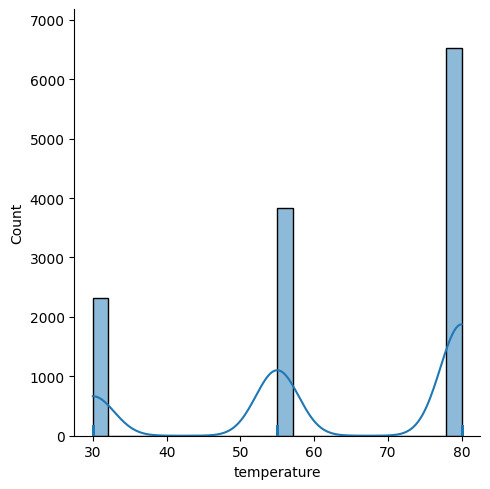

In [ ]:
sns.displot(data.temperature, kde = True, rug = True)

In above plot, temerature at 80 has more distribution.

## What portion of temparature has accepted coupons?

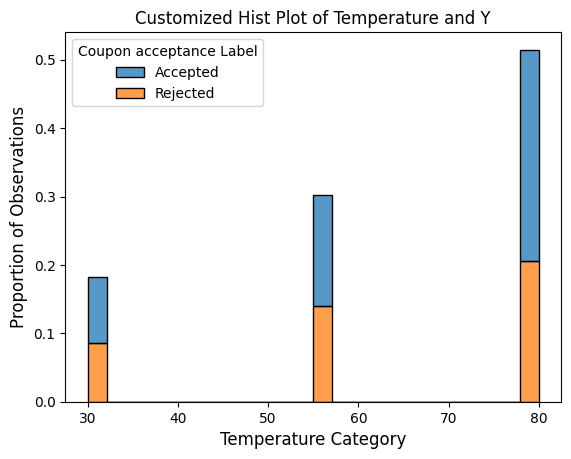

In [ ]:

temp_df = data[['temperature', 'Y']].copy()
temp_df["outcome"] = temp_df["Y"].map({0: "Rejected", 1: "Accepted"})

ax = sns.histplot(data=temp_df, x='temperature', hue='outcome', stat="proportion", multiple="stack")

ax.set_xlabel("Temperature Category", fontsize=12)
ax.set_ylabel("Proportion of Observations", fontsize=12)
ax.set_title("Customized Hist Plot of Temperature and Y")

ax.get_legend().set_title("Coupon acceptance Label")

plt.show()


In [ ]:
temparature_summary_df = bivariate_analysis(data, 'temperature')
temparature_summary_df

,temperature,Total,Accepted,Rejected,Accepted%,Rejected%
2,80,6528,3919,2609,60.034,39.966
1,55,3840,2061,1779,53.672,46.328
0,30,2316,1230,1086,53.109,46.891


From above histogram, temperature divide by Y(accepted or rejcted).  At temperature 80 has more propotion of accepted as compared to other temperature.

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.

Create a new DataFrame that contains just the bar coupons.

In [ ]:
bar_df = data[['Bar', 'Y']]



In [ ]:
bar_df.loc[:, 'outcome'] = bar_df['Y'].map({0: "Rejected", 1: "Accepted"})

# Define colors and categories once
color_map = {'Accepted': 'blue', 'Rejected': 'green'}
outcomes = ['Accepted', 'Rejected']

# Create figure with 1 row and 2 columns
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Box Plot", "Bar Plot")
)
px_fig = px.box(bar_df, y='Bar', color='outcome',color_discrete_map=color_map)

for trace in px_fig.data:
    fig.add_trace(trace, row=1, col=1)




# --- Plot the Bar chart in the second subplot ---
for outcome in outcomes:
    counts = bar_df[bar_df['outcome'] == outcome]['Bar'].value_counts()
    fig.add_trace(
        go.Bar(
            x=counts.index,
            y=counts.values,
            name=outcome,
            marker_color=color_map[outcome],
            showlegend=False
        ),
        row=1, col=2
    )

# Use barmode='group' to prevent stacking and show a single legend
fig.update_layout(barmode='group')
fig.show()

/tmp/ipython-input-3044054059.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Box plot
**No clear acceptance**: This is explained by the overlapping boxes and medians. Because the key summary statistics for the Bar variable are so similar and overlap between the two outcomes, Bar alone does not provide a clear distinction between an 'Accepted' and a 'Rejected' result.
## Bar plot
What it reveal is that the number of Accepted vs. Rejected outcomes.

# What proportion of bar coupons were accepted?

In [ ]:
bar_summary_df = bivariate_analysis(bar_df, 'Bar')
bar_summary_df

,Bar,Total,Accepted,Rejected,Accepted%,Rejected%
4,never,5304,2822,2482,53.205,46.795
3,less1,3482,1963,1519,56.376,43.624
0,1~3,2473,1538,935,62.192,37.808
1,4~8,1076,686,390,63.755,36.245
2,gt8,349,201,148,57.593,42.407


In the above plot, we can see that the acceptance percentage for both the 1 to 3 and 4 to 8 times bar is very close (62% is close to 63.7%).

**Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.**

In [ ]:

bar_frequency_3_or_fewer = ['less1', '1~3']
bar_frequency_more_than_3 = ['4~8', 'gt8']
bar_df['category'] = 'Other'
bar_df.loc[bar_df['Bar'].isin(bar_frequency_3_or_fewer), 'category'] = '3 or fewer'
bar_df.loc[bar_df['Bar'].isin(bar_frequency_more_than_3), 'category'] = 'more than 3'

contingency_table = pd.crosstab(
    bar_df['category'],
    bar_df['Y'],
    normalize='index'
) * 100

print("Contingency Table (Percentages):")
print(contingency_table)

/tmp/ipython-input-2374431053.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Contingency Table (Percentages):
Y                    0          1
category                         
3 or fewer   41.209068  58.790932
Other        46.794872  53.205128
more than 3  37.754386  62.245614


This interprets, that bar_frequency_more_than_3 has 62%

In [ ]:

fig = px.bar(
    contingency_table,
    x=contingency_table.index,
    y=contingency_table.columns,
    title='Acceptance and Rejection Rates by Category',
    labels={'x': 'Bar Frequency Category', 'value': 'Percentage'},
    barmode='stack',
    color_discrete_map={'Accepted': 'green', 'Rejected': 'red'}
)

fig.show()

# **Multivariate analysis**

## **Compare** the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others. Is there a difference?

In [ ]:
bar_age_df = data[['Bar','Y','age']].copy()

bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
over_25 = ['26', '31', '36', '41', '46', '50plus']


bar_age_df['bar_age_group'] = 'Other Drivers'
bar_age_df.loc[
    (bar_age_df['Bar'].isin(bar_visits_more_than_once)) & (bar_age_df['age'].isin(over_25)),
    'bar_age_group'
] = 'Bar > 1 & Age > 25'


rates_and_counts = bar_age_df.groupby('bar_age_group').agg(
    accepted_rate=('Y', 'mean'),
    total_count=('Y', 'count')
).reset_index()

rates_and_counts['rejected_rate'] = 1 - rates_and_counts['accepted_rate']

# Transform to a "long" format for plotting
long_format_df = rates_and_counts.melt(
    id_vars=['bar_age_group'],
    value_vars=['accepted_rate', 'rejected_rate'],
    var_name='outcome',
    value_name='rate'
)

print(long_format_df)

fig = px.bar(
    long_format_df,
    x='bar_age_group',
    y='rate',
    color='outcome',
    title='Acceptance and Rejection Rates by Driver Group',
    labels={'bar_age_group': 'Driver Group', 'rate': 'Rate', 'outcome': 'Outcome'},
    barmode='stack',
    color_discrete_map={'accepted_rate': 'green', 'rejected_rate': 'red'}
)
fig.show()

        bar_age_group        outcome      rate
0  Bar > 1 & Age > 25  accepted_rate  0.621534
1       Other Drivers  accepted_rate  0.553548
2  Bar > 1 & Age > 25  rejected_rate  0.378466
3       Other Drivers  rejected_rate  0.446452


Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.

In [ ]:
bar_passenger_occupation = data[['Bar','passanger','occupation','Y']]
bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
passengers_not_kid = 'Kid'
excluded_occupations = ['Farming', 'Fishing', 'Forestry']


bar_passenger_occupation['bar_not_kid_occupation_group'] = 'Other Drivers'

mask =(
    (data['Bar'].isin(bar_visits_more_than_once)) &
    (data['passanger'] != passengers_not_kid) &
    (~data['occupation'].isin(excluded_occupations))
)

bar_passenger_occupation.loc[mask,'bar_not_kid_occupation_group'] ='Bar > 1 & Age not a kid & occupations other than farming, fishing, or forestry '

rates_and_counts = bar_passenger_occupation.groupby('bar_not_kid_occupation_group').agg(
    accepted_rate=('Y', 'mean'),
    total_count=('Y', 'count')
).reset_index()

rates_and_counts['rejected_rate'] = 1 - rates_and_counts['accepted_rate']

# Transform to a "long" format for plotting
long_format_df = rates_and_counts.melt(
    id_vars=['bar_not_kid_occupation_group'],
    value_vars=['accepted_rate', 'rejected_rate'],
    var_name='outcome',
    value_name='rate'
)

print(long_format_df)

fig = px.bar(
    long_format_df,
    x='bar_not_kid_occupation_group',
    y='rate',
    color='outcome',
    title='Acceptance and Rejection Rates by Driver Group',
    labels={'bar_not_kid_occupation_group': 'Driver Group', 'rate': 'Rate', 'outcome': 'Outcome'},
    barmode='stack',
    color_discrete_map={'accepted_rate': 'green', 'rejected_rate': 'red'}
)
fig.show()

                        bar_not_kid_occupation_group        outcome      rate
0  Bar > 1 & Age not a kid & occupations other th...  accepted_rate  0.622114
1                                      Other Drivers  accepted_rate  0.544616
2  Bar > 1 & Age not a kid & occupations other th...  rejected_rate  0.377886
3                                      Other Drivers  rejected_rate  0.455384


/tmp/ipython-input-2117311591.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The data reveals a specific segment of the population that is highly receptive to coupons. This group is composed of individuals in certain occupations—specifically unemployed, students, and those in the computer and math fields. They also share a unique behavioral pattern: they visit bars infrequently (never or less than once a week) and are typically traveling as passengers, either alone or with friends. Targeting this combination of traits is most likely to yield a successful campaign.

The heatmap shows the combined frequency of specific Bar categories and passanger counts. Correlation: "Bar Never" and "Passanger alone" might primarily serve a high-traffic segment, as shown by a yellow color in the upper passenger count range.

**Compare the acceptance rates between those drivers who:**
* go to bars more than once a month, had passengers that were not a kid, and were not widowed OR
* go to bars more than once a month and are under the age of 30 OR
* go to cheap restaurants more than 4 times a month and income is less than 50K.

In [ ]:
bar_visits_more_than_once = ['1~3', '4~8', 'gt8']
under_30 = ['21', '26']
cheap_rest_more_than_4 = 'gt4'
income_less_than_50k = ['$37500 - $49999', '$25000 - $37499', '$12500 - $24999', 'Less than $12500']

condition1 = (
    data['Bar'].isin(bar_visits_more_than_once) &
    (data['passanger'] != 'Kid') &
    (data['maritalStatus'] != 'Widowed')
)

condition2 = (
    data['Bar'].isin(bar_visits_more_than_once) &
    (data['age'].isin(under_30))
)

condition3 = (
    (data['RestaurantLessThan20'] == cheap_rest_more_than_4) &
    (data['income'].isin(income_less_than_50k))
)

# Group 1: Drivers who satisfy ANY of the conditions (OR)
specific_group = data[condition1 | condition2 | condition3]

# Group 2: All other drivers (using the ~ operator to invert the mask)
other_drivers = data[~(condition1 | condition2 | condition3)]

# Calculate acceptance rates
rate_specific_group = specific_group['Y'].mean()
rate_other_drivers = other_drivers['Y'].mean()

print(f"Acceptance rate for specific group: {rate_specific_group:.2%}")
print(f"Acceptance rate for all other drivers: {rate_other_drivers:.2%}")

Acceptance rate for specific group: 62.21%
Acceptance rate for all other drivers: 54.46%


Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

# **Independent Investigation**
Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.

In [ ]:
numeric_cols = ['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min','direction_same','direction_opp','has_children']
data[numeric_cols].describe()

,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,has_children
count,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,1.0,0.561495,0.119126,0.214759,0.785241,0.414144
std,0.0,0.496224,0.323950,0.410671,0.410671,0.492593
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.0,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric)

In [ ]:
corr_matrix = data[numeric_cols].corr()

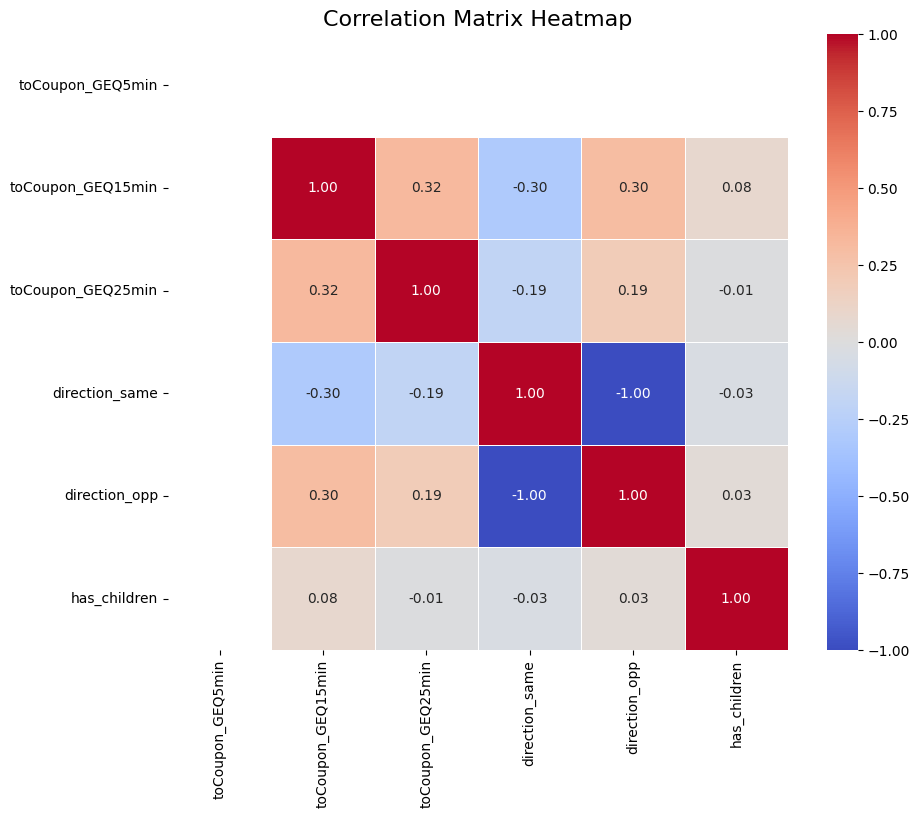

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

The above plot shows that there is no strong correlaction. However, toCoupon_GEQ5min and toCoupon_GEQ15min have 0.32 moderate correlation.

In [ ]:
result = data.groupby('Y')[numeric_cols].mean()
print(result)

   toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  \
Y                                                                           
0               1.0           0.607965           0.157654        0.207892   
1               1.0           0.526214           0.089875        0.219972   

   direction_opp  has_children  
Y                               
0       0.792108      0.439898  
1       0.780028      0.394591  


In the above table, we can see these doesn't contribute to acceptance.

## Joint, marginal, and conditional probability for weather/coupon

In [ ]:

contingency_table = pd.crosstab(data['weather'], data['coupon'])
print( contingency_table)


# Joint Probability
joint_probability = pd.crosstab(data['weather'], data['coupon'], normalize=True)
print("\nJoint Probability:\n", joint_probability)

# Marginal Probability
marginal_weather = joint_probability.sum(axis=1)
marginal_coupon = joint_probability.sum(axis=0)
print("\nMarginal Probability for weather:\n", marginal_weather)
print("\nMarginal Probability for coupon:\n", marginal_coupon)

# Conditional Probability
conditional_coupon_given_weather = pd.crosstab(data['weather'], data['coupon'], normalize='index')
print("\nConditional Probability P(weather | coupon):\n", conditional_coupon_given_weather)

# Using 'normalize='columns' gives P(weather | coupon)
conditional_weather_given_coupon = pd.crosstab(data['weather'], data['coupon'], normalize='columns')
print("\nConditional Probability P(coupon | weather):\n", conditional_weather_given_coupon)




coupon    Bar  Carry out & Take away  Coffee House  Restaurant(20-50)  \
weather                                                                 
Rainy     430                    319           226                 65   
Snowy     239                    307           303                180   
Sunny    1348                   1767          3467               1247   

coupon   Restaurant(<20)  
weather                   
Rainy                170  
Snowy                376  
Sunny               2240  

Joint Probability:
 coupon        Bar  Carry out & Take away  Coffee House  Restaurant(20-50)  \
weather                                                                     
Rainy    0.033901               0.025150      0.017818           0.005125   
Snowy    0.018843               0.024204      0.023888           0.014191   
Sunny    0.106276               0.139309      0.273336           0.098313   

coupon   Restaurant(<20)  
weather                   
Rainy           0.013403  
Snowy      

In [ ]:
joint_dist_raw = contingency_table
joint_dist_index = conditional_coupon_given_weather
joint_dist_columns = conditional_weather_given_coupon

# 3. Create figure with subplots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        'Joint Distribution',
        'weather given coupon P(weather|coupon)',
        'coupon given weather P(coupon|weather)'
    ),
    horizontal_spacing=0.1
)


fig.add_trace(go.Heatmap(
    z=joint_dist_raw.values,
    x=joint_dist_raw.columns,
    y=joint_dist_raw.index,
    colorscale='viridis',
    showscale=False
), row=1, col=1)

fig.add_trace(go.Heatmap(
    z=joint_dist_index.values,
    x=joint_dist_index.columns,
    y=joint_dist_index.index,
    colorscale='viridis',
    showscale=False
), row=1, col=2)

fig.add_trace(go.Heatmap(
    z=joint_dist_columns.values,
    x=joint_dist_columns.columns,
    y=joint_dist_columns.index,
    colorscale='viridis',
    showscale=False
), row=1, col=3)

def add_annotations(fig, df, row, col, fmt):
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.iloc[i, j]
            text = fmt.format(value)
            fig.add_annotation(
                text=text,
                x=df.columns[j],
                y=df.index[i],
                xref=f'x{col}',
                yref=f'y{row}',
                showarrow=False,
                font=dict(color='white' if value < df.max().max() / 2 else 'black')
            )

add_annotations(fig, joint_dist_raw, 1, 1, '{:.0f}')
add_annotations(fig, joint_dist_index, 1, 2, '{:.1%}')
add_annotations(fig, joint_dist_columns, 1, 3, '{:.1%}')

fig.update_layout(
    title_text='Joint Distribution Heatmaps with Different Normalization Methods',
    height=400,
    width=1200,
    margin=dict(t=80, b=20),
)

fig.update_yaxes(title_text='Weather', row=1, col=1)
fig.update_yaxes(title_text=None, showticklabels=False, row=1, col=2)
fig.update_yaxes(title_text=None, showticklabels=False, row=1, col=3)

fig.show()

**To find the most frequent combinations overall**

### weather and coupon conditional probability
When looking at the conditional probability of a customer visiting a coffee house given sunny weather, a high percentage like 87% is an example of a clear association we can derive

In [ ]:
# calculates P(Y | weather, coupon)
conditional_prob = pd.crosstab(
    [data['weather'], data['coupon']],
    data['Y'],
    normalize='index'
).reset_index()

# Melt the DataFrame to long format
long_df = conditional_prob.melt(
    id_vars=['weather', 'coupon'],
    value_vars=[0, 1],
    var_name='Outcome',
    value_name='Probability'
)

fig = px.bar(
    long_df,
    x='weather',
    y='Probability',
    color='Outcome',
    facet_col='coupon',
    barmode='group',
    title='Conditional Probability of Outcome by Weather and Coupon'
)

fig.show()

### Probability of acceptance for given coupon and weather
Coupon `Carryout and Take Away, Restaurant(<20)` has more acceptance in sunny weather describes a multi-layered conditional probability.
